In [1]:
from keras.layers import Conv1D, Input, Activation
from keras.models import Model
import scipy.signal as sp
import numpy as np
import tables
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [2]:
coeff_path='/media/taufiq/Data1/heart_sound/heartnetTransfer/filterbankcoeff60.mat'
signal_path='/media/taufiq/Data1/Heart_Sound/Physionet/training/training-a/a0001.wav'
coeff=tables.open_file(coeff_path)
b1=coeff.root.b2[:]
b1=np.hstack(b1)
b1=np.reshape(b1,[b1.shape[0],1,1])
print b1.shape
fs,data=wavfile.read(signal_path)

(61, 1, 1)


In [6]:
filtered=sp.filtfilt(b1[:,0,0],[1],data[:2500])

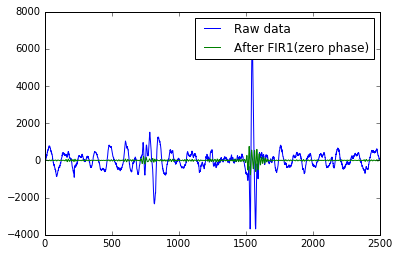

In [8]:
plt.plot(data[:2500],label='Raw data')
plt.plot(filtered,label='After FIR1(zero phase)')
plt.legend()
plt.show()

In [27]:
def FIRnet_w_act(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D(1,61,use_bias=False,weights=[b1],padding='same') (input1)
    x = Activation(activation='relu') (x)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [9]:
def FIRnet(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D(1,61,use_bias=False, weights=[b1])(input1)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [10]:
model = FIRnet(2500)
t = np.reshape(data[:2500],[1,2500,1])
new_data_ = model.predict(t)

In [30]:
model = FIRnet_w_act(2500)
t = np.reshape(data[:2500],[1,2500,1])
new_data = model.predict(t)

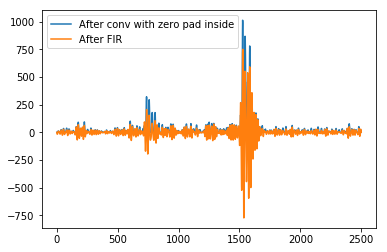

In [31]:
# plt.plot(new_data[0,:,0],label='After conv')
plt.plot(new_data[0,:,0],label='After conv with zero pad inside')
plt.plot(filtered,label='After FIR')
plt.legend()
plt.show()

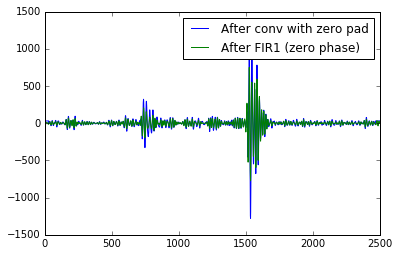

In [11]:
# plt.plot(new_data[0,:,0],label='After conv')
plt.plot(np.pad(new_data_[0,:,0],(30,30),'constant',constant_values=(30, 30)),label='After conv with zero pad')
plt.plot(filtered,label='After FIR1 (zero phase)')
plt.legend()
plt.show()

## Implementing gammatone inside conv layer

In [3]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.engine.topology import InputSpec
import tensorflow as tf
import numpy as np
from keras.utils import conv_utils
from keras.layers import activations, initializers, regularizers, constraints

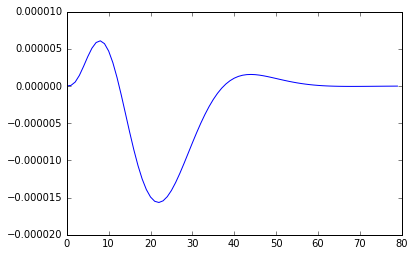

In [78]:
# t = np.arange(80)/float(1000)
t = tf.range(start=0,limit=80./1000.,delta=1/1000.,dtype=K.floatx())
t = tf.expand_dims(input=t,axis=-1)
a = tf.constant([100,100,100],shape=(3,1),dtype=K.floatx())
beta = tf.constant([30,30,30],shape=(3,1),dtype=K.floatx())
fc = tf.constant([10,20,30],shape=(3,1),dtype=K.floatx())
n = tf.constant(4,shape=(1,1),dtype=K.floatx())
res = tf.multiply(tf.multiply(
    tf.matmul(a,tf.pow(x=t,y=n-1),transpose_b=True),
    tf.exp(tf.multiply(-2*np.pi,tf.matmul(beta,t,transpose_b=True)))),
    tf.cos(tf.multiply(2*np.pi,tf.matmul(fc,t,transpose_b=True))))
with tf.Session() as sess:
    plt.plot(sess.run(res)[1])
    plt.show()

In [104]:
# conv_utils.normalize_tuple(80, 1, 'kernel_size') + (1,2)
# for input_channel in range(1,(80,2,3)[1]):
#     print(input_channel)
t = tf.range(start=0,limit=80/float(1000),
                          delta=1/float(1000),dtype=K.floatx())
t

<tf.Tensor 'range_43:0' shape=(80,) dtype=float32>

In [4]:
class Conv1D_gammatone(Layer):

    def __init__(self, filters = 1, kernel_size = 80, rank=1, strides=1, padding='valid',
                 data_format='channels_last',dilation_rate=1, activation=None, use_bias=True,
                 fsHz = 1000.,
                 fc_initializer = initializers.RandomUniform(minval=10,maxval=400),
                 n_order_initializer = initializers.constant(4.),
                 amp_initializer = initializers.constant(10**5),
                 beta_initializer = initializers.RandomNormal(mean=30,stddev=6),
                 bias_initializer='zeros',
                 **kwargs):
        super(Conv1D_gammatone, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size_=kernel_size
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.bias_initializer = initializers.get(bias_initializer)
        self.fc_initializer = initializers.get(fc_initializer)
        self.n_order_initializer = initializers.get(n_order_initializer)
        self.amp_initializer = initializers.get(amp_initializer)
        self.beta_initializer = initializers.get(beta_initializer)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        
        self.fsHz = fsHz
        self.t = tf.range(start=0,limit=kernel_size/float(fsHz),
                          delta=1/float(fsHz),dtype=K.floatx())
        self.t = tf.expand_dims(input=self.t,axis=-1)

    
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        self.kernel_shape = self.kernel_size + (input_dim, self.filters)

        ## Add learnable parameters
        self.fc = self.add_weight(shape=(self.filters,1),
                                      initializer=self.fc_initializer,
                                      name='fc')
        self.n_order = self.add_weight(shape=(1,1),
                                      initializer=self.n_order_initializer,
                                      name='n')
        self.amp = self.add_weight(shape=(self.filters,1),
                                      initializer=self.amp_initializer,
                                      name='a')
        self.beta = self.add_weight(shape=(self.filters,1),
                                      initializer=self.beta_initializer,
                                      name='beta')
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    

    def call(self, inputs):
        
        # Get gammatone impulse response
        
        gammatone = self.impulse_gammatone()
        gammatone = tf.expand_dims(gammatone,axis=-2) ## Considering single input channel
        
        if self.kernel_shape[1] > 1:
            raise ValueError('Number of channels for input to gammatone layer'
                             'should be 1.')
        
        outputs = K.conv1d(
            inputs,
            gammatone,
            strides=self.strides[0],
            padding='same',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate[0])
    
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)
    
    def impulse_gammatone(self):
        
        gammatone = tf.multiply(tf.multiply(
                        tf.matmul(self.amp,tf.pow(x=self.t,y=self.n_order-1),
                                  transpose_b=True),
                        tf.exp(tf.multiply(-2*np.pi,tf.matmul(self.beta,self.t,
                                                              transpose_b=True)))),
                        tf.cos(tf.multiply(2*np.pi,tf.matmul(self.fc,self.t,
                                                             transpose_b=True))))
        gammatone = tf.transpose(gammatone)
        return gammatone
    

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size_,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'fsHz': self.fsHz,
            'fc_initializer': initializers.serialize(self.fc_initializer),
            'n_order_initializer': initializers.serialize(self.n_order_initializer),
            'amp_initializer': initializers.serialize(self.amp_initializer),
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
        }
        base_config = super(Conv1D_gammatone, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
def FIRnet_gammatone(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D_gammatone(kernel_size=81,filters=3,fsHz=1000,use_bias=False)(input1)
#     x = Conv1D_gammatone(kernel_size=80,filters=3,fsHz=1000,use_bias=False)(x)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [14]:
model = FIRnet_gammatone(2500)
t = np.reshape(data[:2500]/float(np.max(data[:2500])),[1,2500,1])
new_data_ = model.predict(t)
print new_data_.shape

(1, 2500, 3)


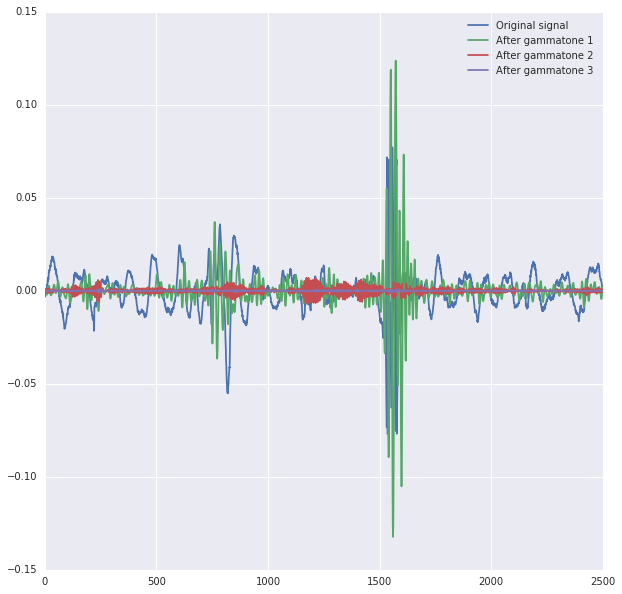

In [15]:
# plt.plot(new_data[0,:,0],label='After conv')
plt.figure(figsize=(10,10))
plt.plot(10*data[:2500]/float(np.var(data[:2500])),label='Original signal')
plt.plot(new_data_[0,:,0],label='After gammatone 1')
plt.plot(new_data_[0,:,1],label='After gammatone 2')
plt.plot(new_data_[0,:,2],label='After gammatone 3')
# plt.plot(filtered,label='After FIR1 (zero phase)')
plt.legend()
plt.show()

[array([[ 57.85155],
       [113.01084],
       [167.99686]], dtype=float32), array([[4.]], dtype=float32), array([[100000.],
       [100000.],
       [100000.]], dtype=float32), array([[22.691906],
       [21.749432],
       [36.581142]], dtype=float32)]


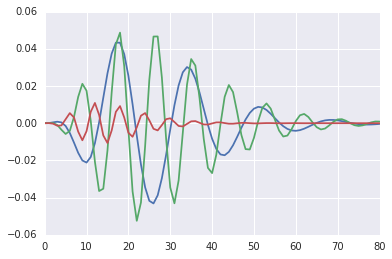

In [16]:
print(model.layers[1].get_weights())
with K.get_session() as sess:
    impulse_gammatone = sess.run(model.layers[1].impulse_gammatone())
plt.plot(impulse_gammatone)
plt.show()

In [39]:
kernel_size=60
if kernel_size%2:
    kernel_size = conv_utils.normalize_tuple(kernel_size/2+1,1,'kernel_size') 
else:
    kernel_size = conv_utils.normalize_tuple(kernel_size/2,1,'kernel_size')
print kernel_size[0]

30


## Linear Convolutional filter. Learns only half the filter

In [47]:
class Conv1D_zerophase_linear(Layer):
    
    def __init__(self,filters,kernel_size,rank=1,strides=1,padding='valid',data_format='channels_last',dilation_rate=1,activation=None,use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,bias_constraint=None,**kwargs):
        super(Conv1D_zerophase_linear, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        if kernel_size%2:
            self.kernel_size = conv_utils.normalize_tuple(kernel_size/2+1,rank,'kernel_size') 
        else:
            self.kernel_size = conv_utils.normalize_tuple(kernel_size/2,rank,'kernel_size')
        print self.kernel_size[0]
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True


    def call(self, inputs):
        
        if self.kernel_size[0]%2==0:
            flipped = tf.reverse(self.kernel,axis=[0])
        else:
            flipped = tf.reverse(self.kernel[1:,:,:],axis=[0])
#         print (flipped)
        conv_kernel = tf.concat([flipped,self.kernel],axis=0)
#         print (conv_kernel)
        
        
        outputs = K.conv1d(
                inputs,
                conv_kernel,
                strides=self.strides[0],
                padding='same',
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
#         print tf.shape(outputs)
        outputs = tf.reverse(outputs,axis=[1])
        outputs = K.conv1d(
                outputs,
                conv_kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
#         print tf.shape(outputs)
        outputs = tf.reverse(outputs,axis=[1])
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

        
    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Conv1D_zerophase_linear, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



In [48]:
def FIRnet_linearphase(input_size):
    input1=Input(shape=(input_size,1))
    x = Conv1D_zerophase_linear(1,61,use_bias=False,weights=[b1[30:]])(input1)
    model =Model(input1,x)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])    
    return model

In [49]:
model = FIRnet_linearphase(2500)
t = np.reshape(data[:2500],[1,2500,1])
new_data_ = model.predict(t)
print new_data_

31
[[[ -8.50337887]
  [ -3.51722765]
  [  2.27529454]
  ..., 
  [ -5.42623615]
  [ -8.63265038]
  [-12.50613785]]]


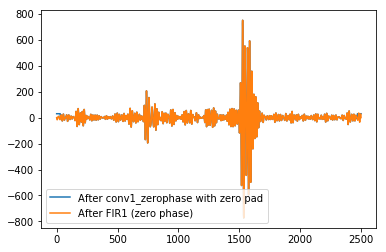

In [43]:
plt.plot(np.pad(new_data_[0,:,0],(30,30),'constant',constant_values=(30, 30)),label='After conv1_zerophase with zero pad')
plt.plot(filtered,label='After FIR1 (zero phase)')
plt.legend()
plt.show()